In [114]:

import sys,os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils.pg import PgClass
from src.constants import project_dir, DATABASE_DB, DATABASE_USER, DATABASE_PW, DATABASE_HOST, DATABASE_PORT

import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.stats import rankdata

from dateutil.relativedelta import relativedelta
import datetime
import holidays

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import statsmodels.api as sm

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px

from itertools import cycle


import IPython
import IPython.display
from IPython.display import display, HTML, Markdown
from IPython.display import clear_output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x:'%.4f'%x)
import warnings
warnings.filterwarnings("ignore")



In [2]:
pg_conn = PgClass(DATABASE_DB, DATABASE_USER, DATABASE_PW, DATABASE_HOST, DATABASE_PORT)


In [3]:
#configurations

start_date = '2016-01-01'
train_start_date_input, train_end_date_input = datetime.date(2016, 1, 1), datetime.datetime.today().date()
n_forecast =90
n_input_width=30
# one of 'VOX', 'VCR', 'VDC', 'VDE', 'VFH', 'VHT', 'VIS', 'VGT', 'VAW', 'VNQ', 'VPU', 'QQQ'
target_etf = 'VFH'


## Collect data

In [4]:
leading_q = f"""
SELECT fc.metric, activity_date, value, frequency, title
FROM fred.fact_metric fc
JOIN fred.dim_metric dim
ON fc.metric = dim.metric
WHERE activity_date >='{start_date}'
AND fc.metric in ('M2', 'T10YFF', 'DGS10', 'SP500', 'UMCSENT', 'PERMIT','ANDENO','AWHAEMAN','DTCDISA066MSFRBNY'
--,'ICSA'
);
             """
leading_df = pd.read_sql_query(leading_q, pg_conn.connection)

In [5]:
etf_q = f"""
select ticker, activity_date, close
from stock.fact_stock_price
where activity_date >='{start_date}'
 and ticker in ('VOX', 'VCR', 'VDC', 'VDE', 'VFH', 'VHT', 'VIS', 'VGT', 'VAW', 'VNQ', 'VPU','QQQ')"""
etf_df = pd.read_sql_query(etf_q, pg_conn.connection)

In [6]:
# pivots the leading indicators and etf to predict
leading_metric_df = leading_df.groupby(['metric','frequency','title']
                                      ).count().index.to_frame(index=False, name=['metric','frequency','title'])
leading_pivoted = pd.pivot_table(leading_df, index='activity_date', columns='metric', values='value',aggfunc='sum').reset_index()

etf_pivoted = pd.pivot_table(etf_df, index='activity_date',columns='ticker',values='close',aggfunc='sum').reset_index()


In [7]:
data_df = etf_pivoted.merge(leading_pivoted, on=['activity_date'], how='outer')\
            .sort_values(by=['activity_date'])\
            .reset_index(drop=True)

In [8]:
data_df = data_df.set_index('activity_date').asfreq('D')
data_df.index = data_df.index.date
etf_list = etf_df.ticker.unique().tolist()
# TODO:
# etf_list=['VFH']
leading_metric_list = leading_metric_df.metric.unique().tolist()
# replace the fred metric with 0 value to null
data_df = data_df.replace(0,np.nan)
# forwardfill then backwardfill null value to fill all null value
data_df = data_df.fillna(method='ffill').dropna()

In [9]:
# create date_features
data_df['weekday']=data_df.index.map(lambda x:x.weekday())
data_df['is_weekend'] = np.where(data_df['weekday'].isin([0,6]),1,0)
us_holidays = holidays.UnitedStates()
data_df['is_holiday']=data_df.index.map(lambda x: 1 if x in us_holidays else 0)
date_feature_list = ['weekday','is_weekend','is_holiday']

## Explore Data

In [10]:
def plot_trends(df):
    for i in df.columns:
        plt.figure(figsize=(6,2))
        plt.plot(df.index, df[i])
        plt.title(i)
        plt.show()

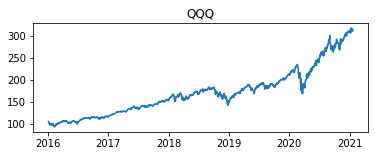

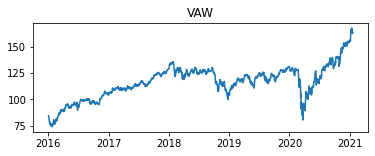

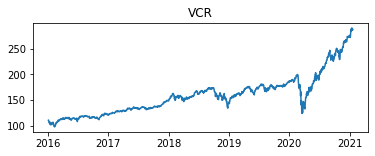

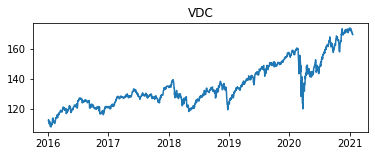

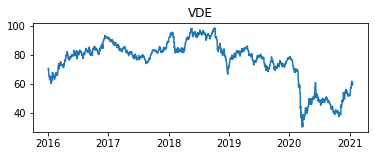

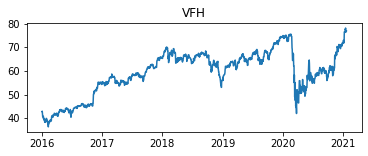

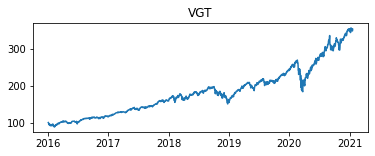

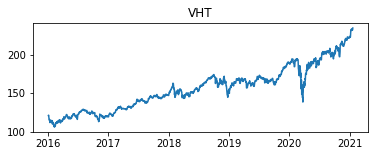

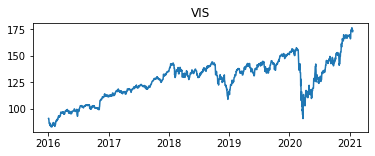

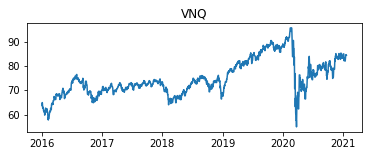

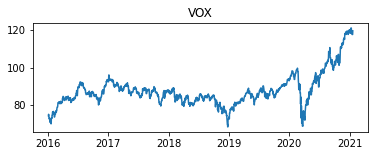

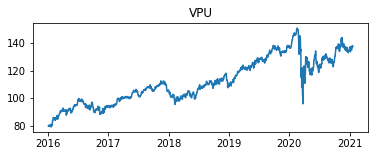

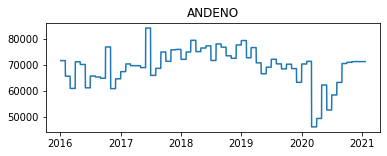

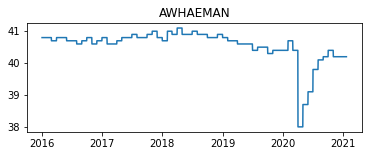

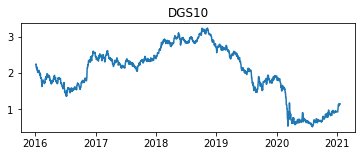

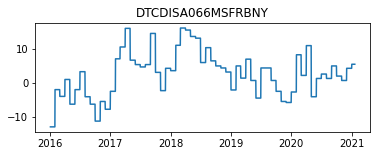

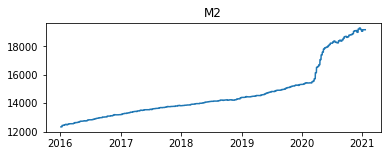

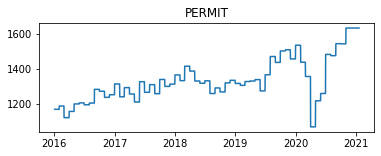

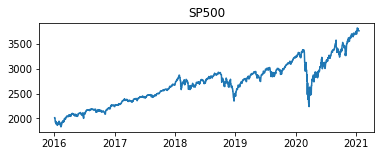

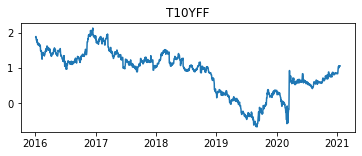

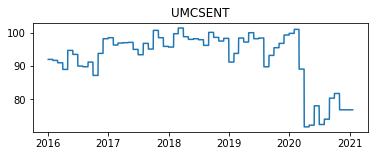

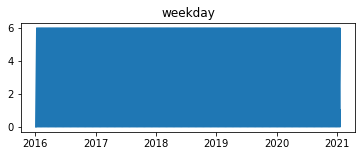

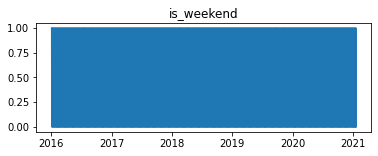

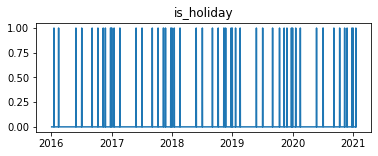

In [11]:
plot_trends(data_df)

<AxesSubplot:>

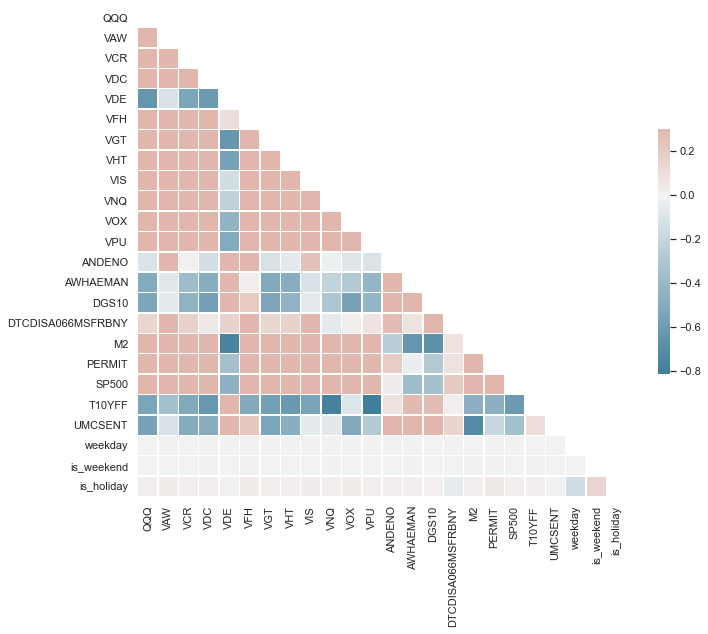

In [12]:
# correlation matrix
sns.set_theme(style="white")


# Compute the correlation matrix
corr = data_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [13]:
# corr[target_etf].sort_values()

## Create dataset for prediction

In [14]:
# use related data for model
data_start_date = data_df.index.min()
data_end_date = data_df.index.max()
train_start_date = max(data_start_date, train_start_date_input) 
train_end_date = min(data_end_date, train_end_date_input)
# for deep learning model in this Notebook, the forecast period is decided by n_input_width rather than n_forecast
forecast_start_date, forecast_end_date = train_end_date+relativedelta(days=1), train_end_date+relativedelta(days=1+n_forecast)

df = data_df.loc[(data_df.index>= train_start_date) & (data_df.index<= train_end_date),
             etf_list+leading_metric_list+date_feature_list].copy()


## VAR

In [15]:
diff_order = 1
diff_df = df.diff(diff_order).dropna()
diff_df.columns = [ i +'_diff' for i in diff_df.columns]

In [16]:
# Stationary test
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

for name, column in diff_df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "QQQ_diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.2689
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "VOX_diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.5392
 No. Lags Chosen       = 12
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "VCR_diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance L

    Augmented Dickey-Fuller Test on "UMCSENT_diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -42.8888
 No. Lags Chosen       = 0
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "weekday_diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5005888996656657.0
 No. Lags Chosen       = 5
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "is_weekend_diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-St

In [17]:
def test_stationarity(timeseries, label, title):
    '''
    function to test  stationary
    '''
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    plt.figure(figsize=(10,6))
    orig = plt.plot(timeseries, color='black',label=label)
    #mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xticks(rotation=90)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()
    
    #Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)'%key] = value
    if dfoutput['p-value']<=0.05:
        conclusion = "stationary"
    else:
        conclusion = "not stationary"
    print("Dickey-Fuller Test: " + conclusion)
    dfoutput = dfoutput.reset_index()
    dfoutput.columns=['metric', 'value']
    display(HTML(dfoutput.to_html()))
    
    return


QQQ_diff


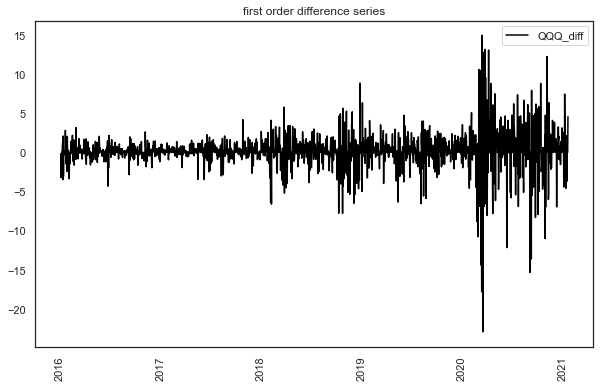

Dickey-Fuller Test: stationary


VOX_diff


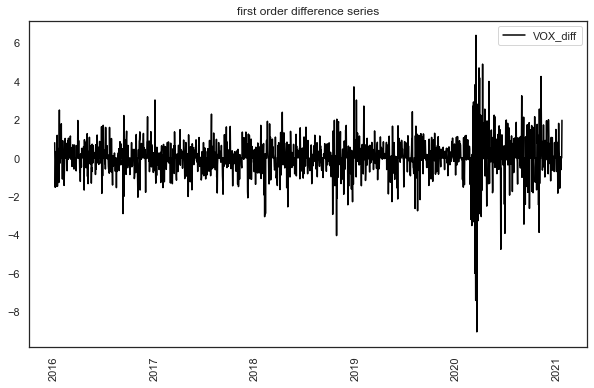

Dickey-Fuller Test: stationary


VCR_diff


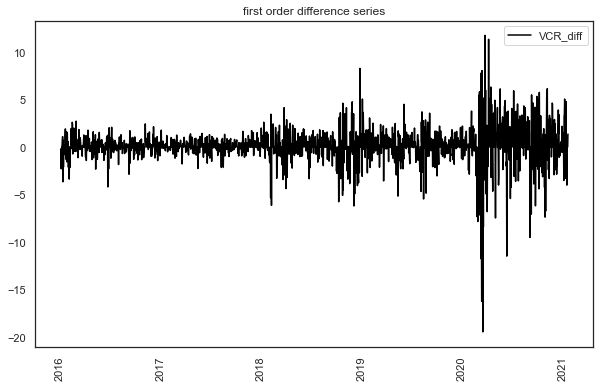

Dickey-Fuller Test: stationary


VDC_diff


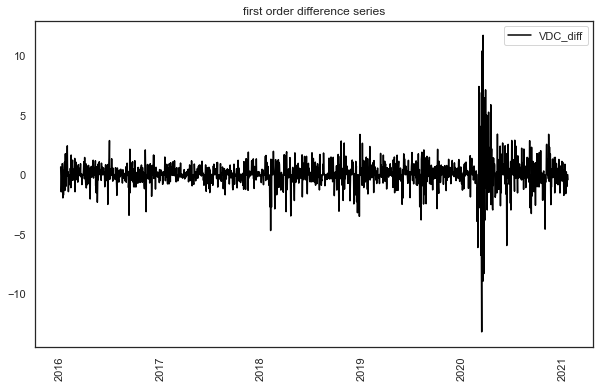

Dickey-Fuller Test: stationary


VDE_diff


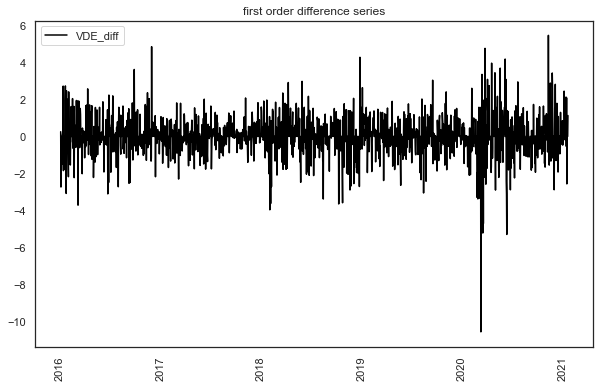

Dickey-Fuller Test: stationary


VFH_diff


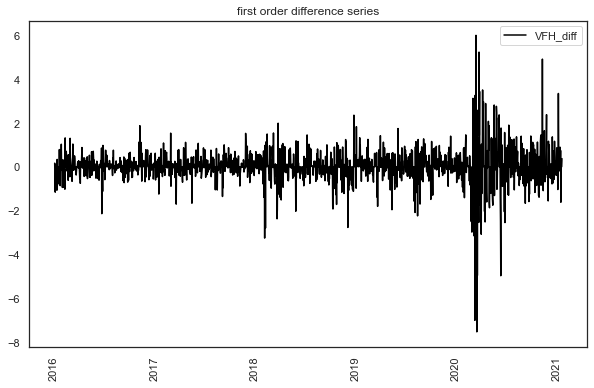

Dickey-Fuller Test: stationary


VHT_diff


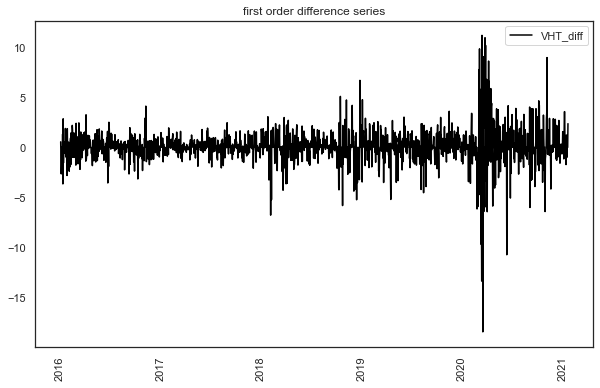

Dickey-Fuller Test: stationary


VIS_diff


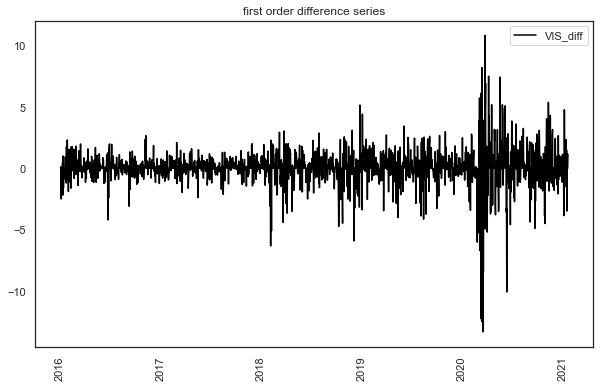

Dickey-Fuller Test: stationary


VGT_diff


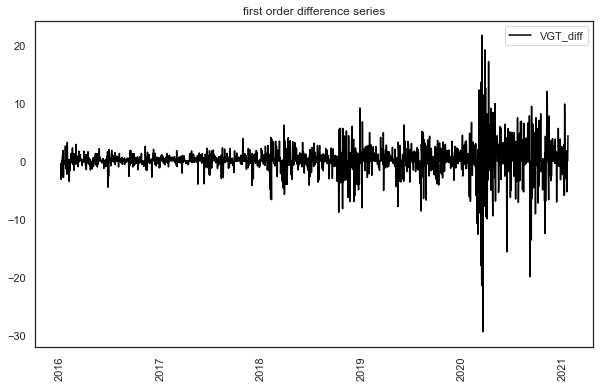

Dickey-Fuller Test: stationary


VAW_diff


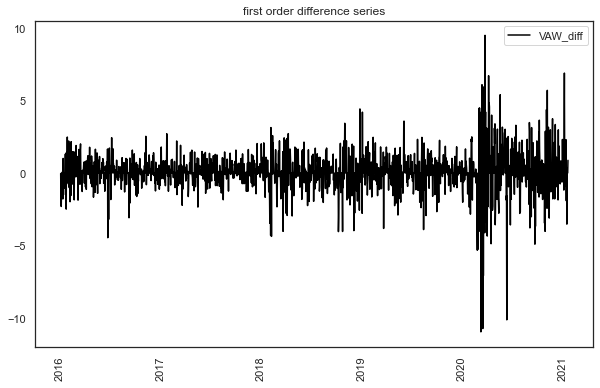

Dickey-Fuller Test: stationary


VNQ_diff


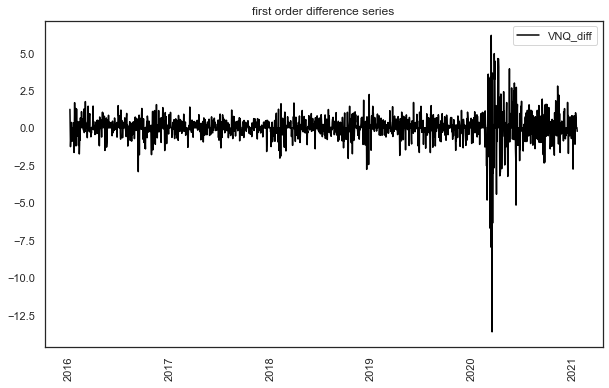

Dickey-Fuller Test: stationary


VPU_diff


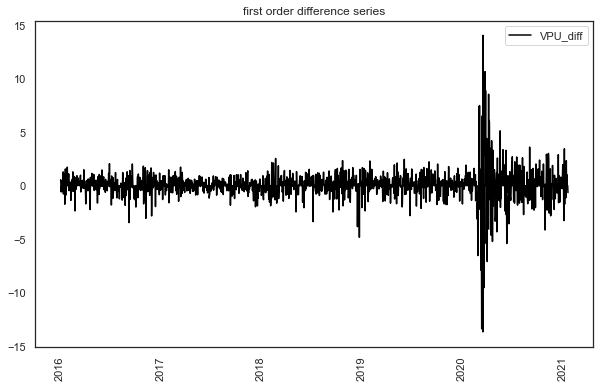

Dickey-Fuller Test: stationary


ANDENO_diff


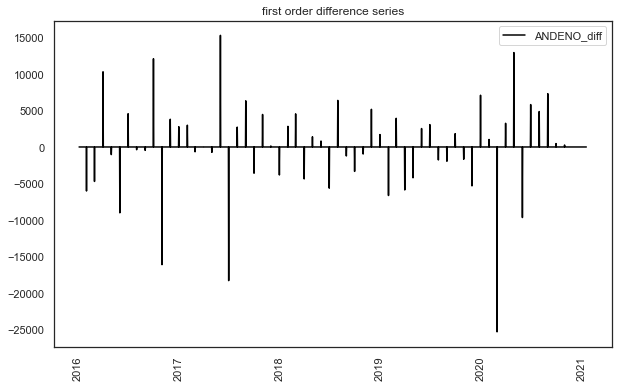

Dickey-Fuller Test: stationary


AWHAEMAN_diff


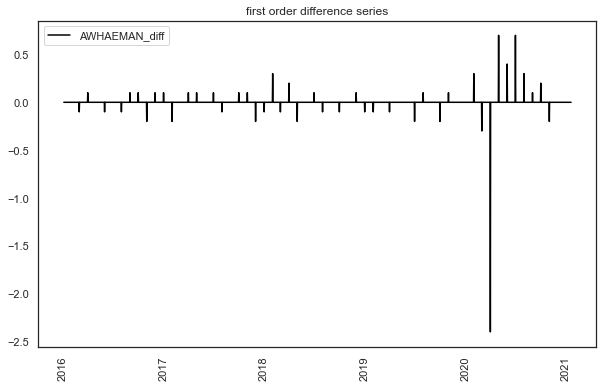

Dickey-Fuller Test: stationary


DGS10_diff


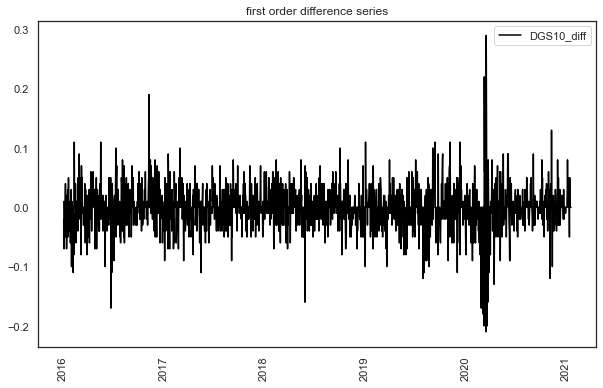

Dickey-Fuller Test: stationary


DTCDISA066MSFRBNY_diff


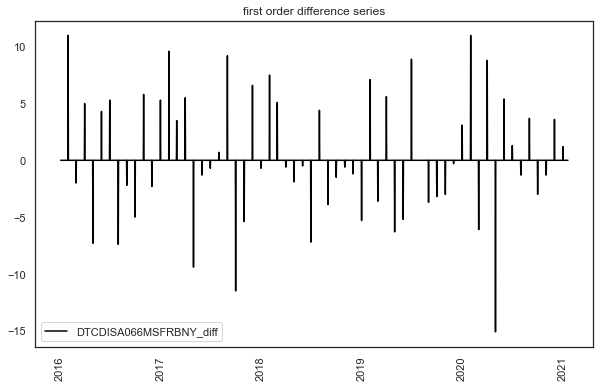

Dickey-Fuller Test: stationary


M2_diff


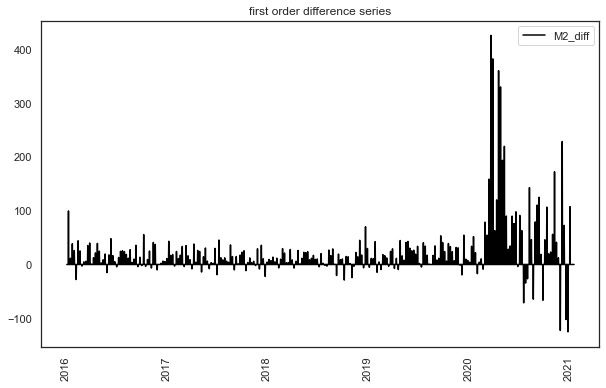

Dickey-Fuller Test: stationary


PERMIT_diff


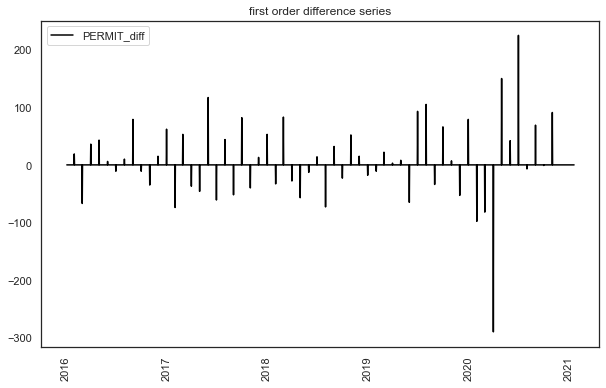

Dickey-Fuller Test: stationary


SP500_diff


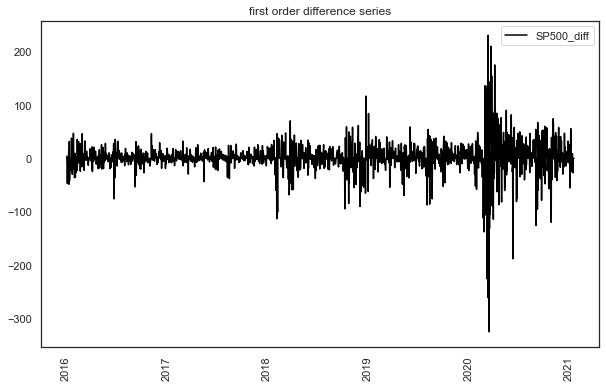

Dickey-Fuller Test: stationary


T10YFF_diff


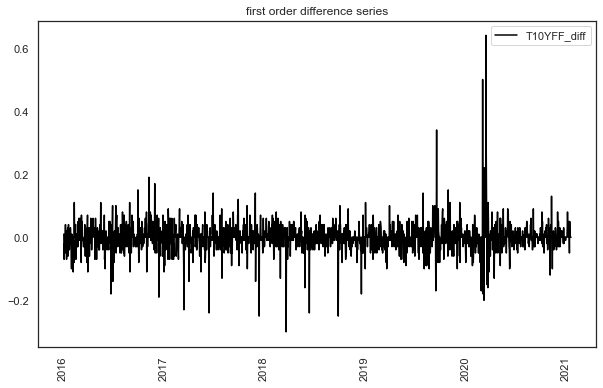

Dickey-Fuller Test: stationary


UMCSENT_diff


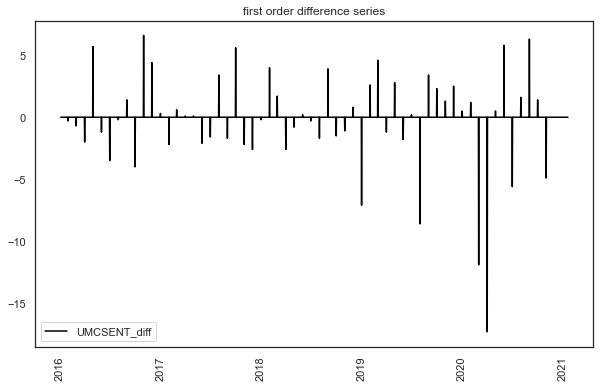

Dickey-Fuller Test: stationary


weekday_diff


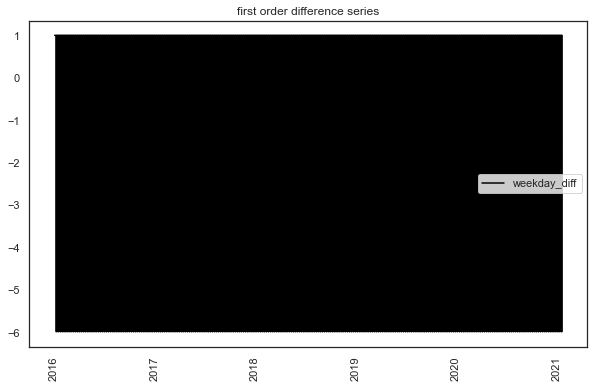

Dickey-Fuller Test: stationary


is_weekend_diff


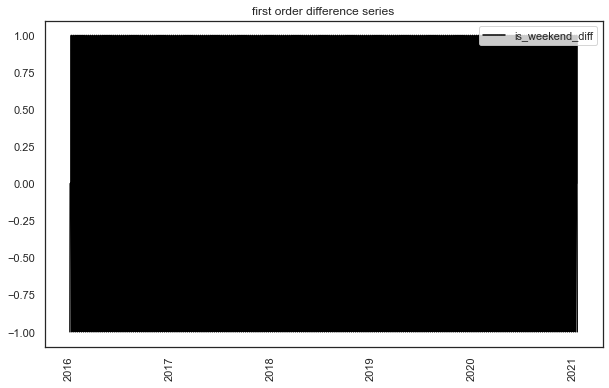

Dickey-Fuller Test: stationary


is_holiday_diff


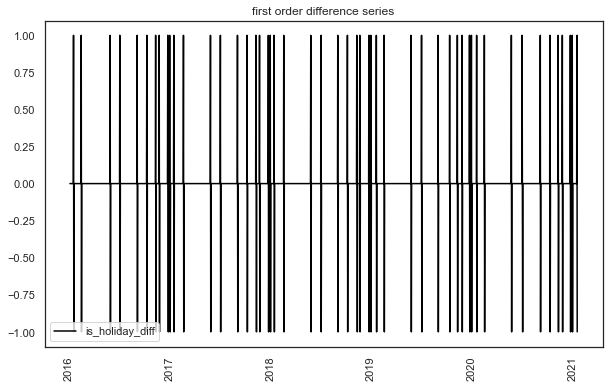

Dickey-Fuller Test: stationary


In [18]:
_ = diff_df
for col in _.columns:
    print(col)
    test_stationarity(_[col], label=col, title='first order difference series')


## VAR model

/Users/yilin/Documents/Projects/market_analysis/market_analysis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


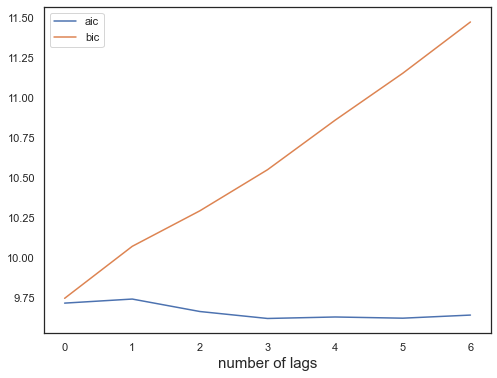

In [19]:

train_df_var = diff_df[[target_etf+"_diff"]+[i+'_diff' for i in leading_metric_list]].copy()

model = VAR(train_df_var)
aic, bic = [], []

x = np.arange(7)
for i in x:
    result = model.fit(i)
    aic.append(result.aic)
    bic.append(result.bic)

plt.figure(figsize=(8,6))
plt.plot(x, aic, label='aic')
plt.plot(x, bic, label='bic')
plt.xlabel("number of lags", fontsize=15)
plt.legend()
plt.show()


In [20]:
# actually, this is not a good example of using VAR model
maxlags = 7
model_result_var = model.fit(maxlags=maxlags, ic = 'bic', trend = 'c')  #do not use linear trend since it stationarized after differencing
num_lag_chosen = model_result_var.k_ar
print(num_lag_chosen)

print(model_result_var.summary())


0
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 19, Jan, 2021
Time:                     21:45:44
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    9.74733
Nobs:                     1842.00    HQIC:                   9.72842
Log likelihood:          -35076.5    FPE:                    16603.5
AIC:                      9.71737    Det(Omega_mle):         16513.6
--------------------------------------------------------------------
Results for equation VFH_diff
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.018498         0.017396            1.063           0.288

Results for equation ANDENO_diff
           coefficient       std. error           t-stat            prob
-----------------------------------------------------

## Tensorflow Models
This part is mainly copied from this [page](https://www.tensorflow.org/tutorials/structured_data/time_series#top_of_page). I changed the data transformation method to make the time series stationary.

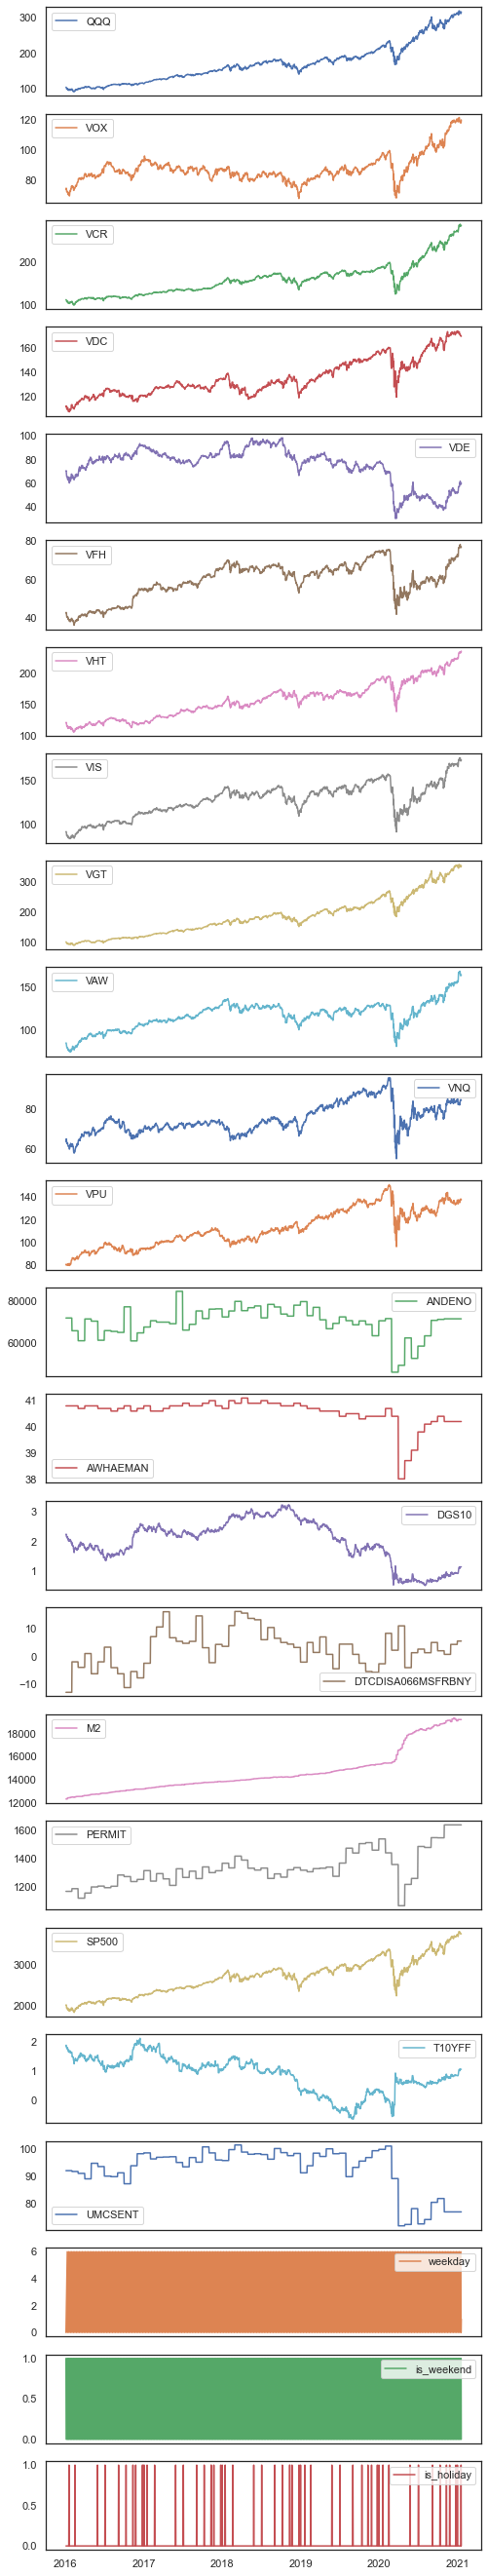

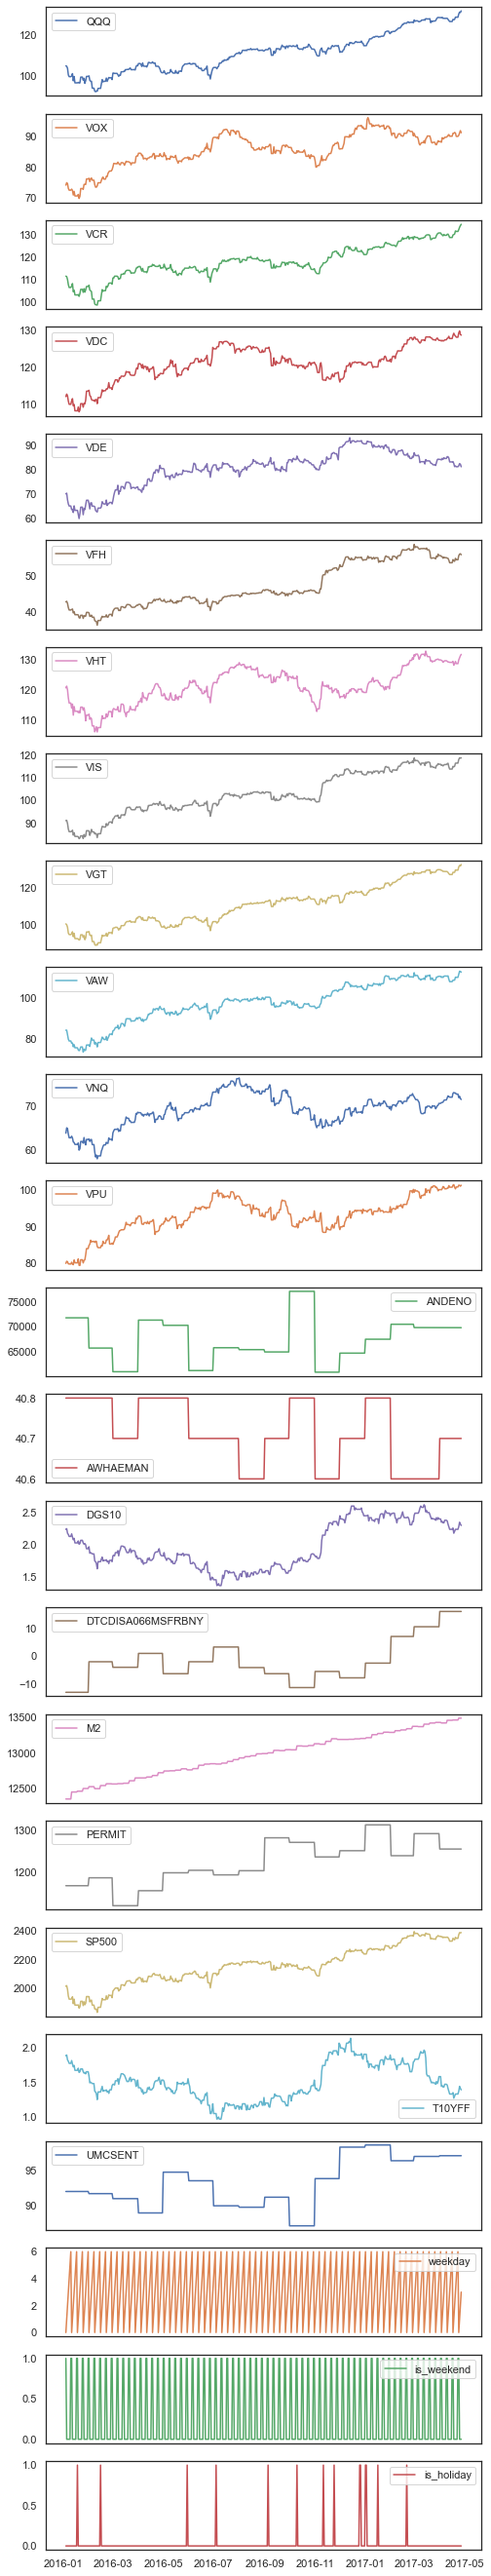

In [21]:

plot_cols = etf_list+leading_metric_list+date_feature_list
mpl.rcParams['figure.figsize'] = (8, len(plot_cols)*2)
mpl.rcParams['axes.grid'] = False

plot_features = df[plot_cols]
# plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
# plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

mpl.rcParams['figure.figsize'] = (8, 6)


In [22]:
df.describe().transpose()


count       mean       std        min        25%  \
QQQ               1843.0000   170.4144   53.4264    92.3169   128.1601   
VOX               1843.0000    87.7488    8.9293    68.2853    82.9482   
VCR               1843.0000   159.0277   38.3782    98.7416   129.8815   
VDC               1843.0000   135.5272   14.9720   107.8460   125.1117   
VDE               1843.0000    75.2231   15.0413    30.1825    71.0126   
VFH               1843.0000    59.2124    9.2994    36.3279    54.7799   
VHT               1843.0000   156.2878   28.6405   106.1593   130.8704   
VIS               1843.0000   127.2616   19.0882    83.0254   114.8511   
VGT               1843.0000   183.3056   65.2759    88.7203   129.5078   
VAW               1843.0000   116.5490   15.9319    73.7096   107.4933   
VNQ               1843.0000    74.8672    7.2898    55.0331    69.9785   
VPU               1843.0000   112.1520   16.3952    79.3502    99.7061   
ANDENO            1843.0000 69681.9409 6965.9932 46151.0000 66049.0000   
AWHAEMAN          1843.0000    40.5571    0.5203    38.0000    40.4000   
DGS10             1843.0000     2.0129    0.7256     0.5200     1.6000   
DTCDISA066MSFRBNY 1843.0000     2.6696    6.5697   -13.0000    -2.3000   
M2                1843.0000 14644.1381 1824.1700 12342.8000 13431.8000   
PERMIT            1843.0000  1331.1628  122.8785  1066.0000  1257.0000   
SP500             1843.0000  2695.7971  436.7074  1829.0800  2365.5850   
T10YFF            1843.0000     0.8711    0.6087    -0.6600     0.4700   
UMCSENT           1843.0000    92.6566    8.0211    71.8000    90.0000   
weekday           1843.0000     2.9973    2.0012     0.0000     1.0000   
is_weekend        1843.0000     0.2859    0.4520     0.0000     0.0000   
is_holiday        1843.0000     0.0304    0.1717     0.0000     0.0000   

                         50%        75%        max  
QQQ                 164.8851   190.5870   319.0300  
VOX                  86.1402    90.1510   121.1800  
VCR                 157.0020   174.9130   289.8800  
VDC                 130.9461   146.2084   173.9200  
VDE                  79.4781    83.8911    98.2839  
VFH                  61.1730    65.9751    78.1100  
VHT                 155.9009   170.6573   234.6700  
VIS                 130.1196   139.8898   176.3600  
VGT                 175.5833   214.7719   357.3600  
VAW                 118.4054   126.5725   168.4900  
VNQ                  73.2385    79.8630    95.5405  
VPU                 109.6388   126.6315   151.0158  
ANDENO            70641.0000 73623.0000 84363.0000  
AWHAEMAN             40.7000    40.8000    41.1000  
DGS10                 2.1500     2.5500     3.2400  
DTCDISA066MSFRBNY     3.2000     6.0000    16.2000  
M2                14142.0000 15116.9000 19299.1000  
PERMIT             1316.0000  1387.0000  1635.0000  
SP500              2716.3100  2947.1700  3824.6800  
T10YFF                1.0100     1.3100     2.1300  
UMCSENT              95.7000    98.2000   101.4000  
weekday               3.0000     5.0000     6.0000  
is_weekend            0.0000     1.0000     1.0000  
is_holiday            0.0000     0.0000     1.0000

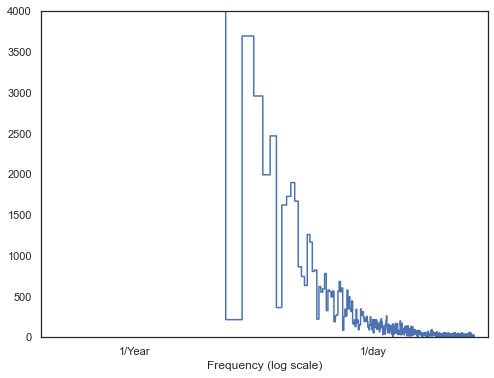

In [23]:
# determine which frequencies are important using an fft
fft = tf.signal.rfft(df[target_etf])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df[target_etf])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 4000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [24]:
# split data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)].copy()
val_df = df[int(n*0.7):int(n*0.9)].copy()
test_df = df[int(n*0.9):].copy()

num_features = df.shape[1]


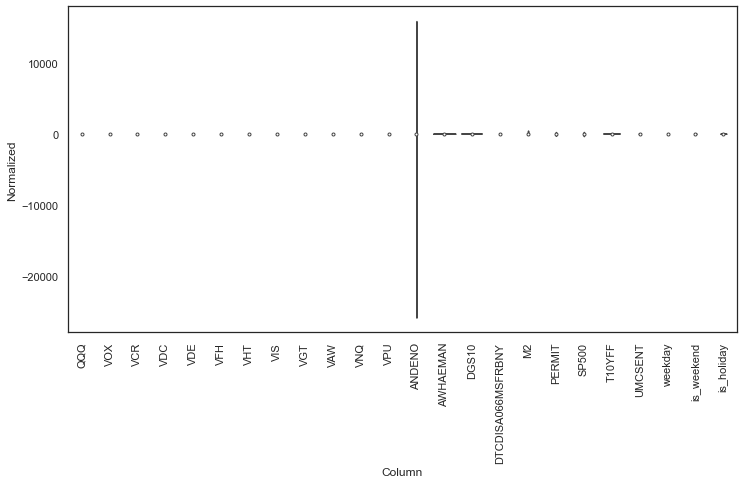

In [25]:
# # normalize data
# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

# # check distribution
# df_std = (df - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)

#  normalize data
# use one degree difference rather than normalization to improve the accuracy of prediction
train_mean = train_df.mean()
train_std = train_df.std()

train_df = train_df.diff(1).dropna()
val_df = val_df.diff(1).dropna()
test_df = test_df.diff(1).dropna()

# check distribution
df_std = df.diff(1).dropna()
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)



### Data Windowing

In [27]:
# generate window
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [28]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=[target_etf])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['VFH']

In [29]:
w2 = WindowGenerator(input_width=n_input_width, label_width=1, shift=1,
                     label_columns=[target_etf])
w2

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['VFH']

In [30]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [31]:
# Stack three slices, the length of the total window:
example_window = tf.stack([
    
                           np.array(train_df[-6*w2.total_window_size:-5*w2.total_window_size]),
    
                           np.array(train_df[-5*w2.total_window_size:-4*w2.total_window_size]),
    
                           np.array(train_df[-4*w2.total_window_size:-3*w2.total_window_size]),
    np.array(train_df[-3*w2.total_window_size:-2*w2.total_window_size]),
                           np.array(train_df[-2*w2.total_window_size:-w2.total_window_size]),
                           np.array(train_df[-w2.total_window_size:])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (6, 31, 24)
Inputs shape: (6, 30, 24)
labels shape: (6, 1, 1)


In [32]:
w2.example = example_inputs, example_labels


In [33]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Date [d]')

WindowGenerator.plot = plot

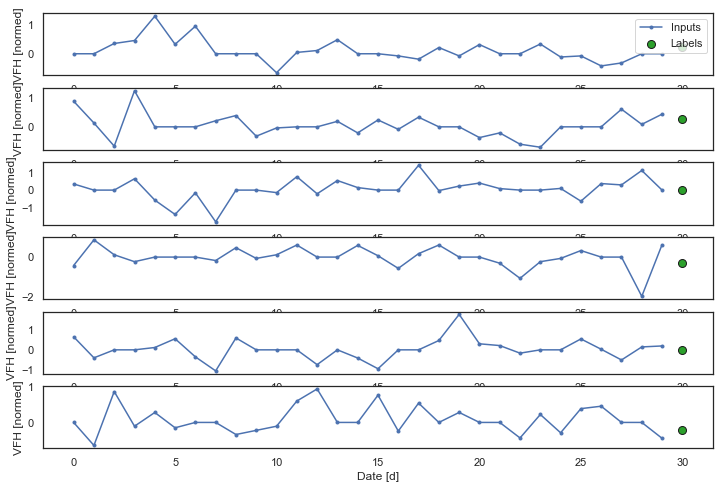

In [34]:
w2.plot(plot_col=target_etf,max_subplots=6)

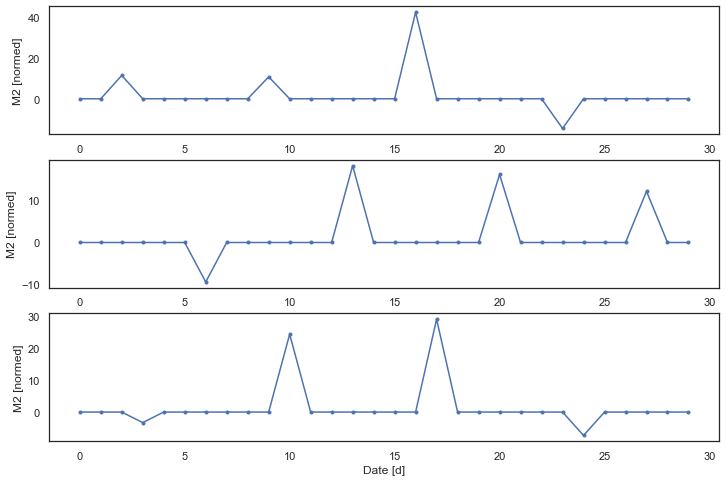

In [35]:
w2.plot(plot_col='M2')


In [36]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [37]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [38]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 30, 24), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [39]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 24)
Labels shape (batch, time, features): (32, 1, 1)


In [40]:
single_step_window = WindowGenerator(
    input_width=n_input_width, label_width=1, shift=1,
    label_columns=[target_etf])
single_step_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['VFH']

In [41]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 24)
Labels shape (batch, time, features): (32, 1, 1)


In [42]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [43]:
# baseline model that use current value
baseline = Baseline(label_index=column_indices[target_etf])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

11/11 [==============================] - 0s 1ms/step - loss: 3.1880 - mean_absolute_error: 1.1044


In [44]:
wide_window = WindowGenerator(
    input_width=n_input_width, label_width=n_input_width, shift=1,
    label_columns=[target_etf])

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['VFH']

In [45]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 30, 24)
Output shape: (32, 30, 1)


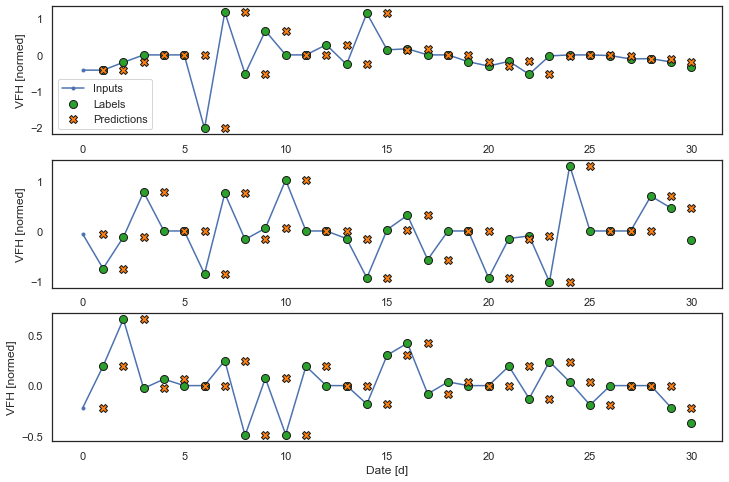

In [46]:
# Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

wide_window.plot(baseline,target_etf)

In [47]:
# Linear model
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [48]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 30, 24)
Output shape: (32, 30, 1)


In [49]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    
    return history

In [50]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
40/40 [==============================] - 2s 34ms/step - loss: 181181.8392 - mean_absolute_error: 59.6364 - val_loss: 352983.9062 - val_mean_absolute_error: 84.7509
Epoch 2/20
40/40 [==============================] - 0s 7ms/step - loss: 140532.7752 - mean_absolute_error: 53.4859 - val_loss: 282526.1250 - val_mean_absolute_error: 77.1451
Epoch 3/20
40/40 [==============================] - 0s 6ms/step - loss: 106856.8626 - mean_absolute_error: 46.9288 - val_loss: 223963.9219 - val_mean_absolute_error: 69.9952
Epoch 4/20
40/40 [==============================] - 0s 6ms/step - loss: 90294.9522 - mean_absolute_error: 43.3310 - val_loss: 173731.3750 - val_mean_absolute_error: 62.9180
Epoch 5/20
40/40 [==============================] - 0s 5ms/step - loss: 72085.3060 - mean_absolute_error: 38.7902 - val_loss: 133704.6562 - val_mean_absolute_error: 56.4355
Epoch 6/20
40/40 [==============================] - 0s 5ms/step - loss: 53457.8626 - mean_absolute_error: 34.1987 - val_loss: 10212

In [51]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Input shape: (32, 30, 24)
Output shape: (32, 30, 1)


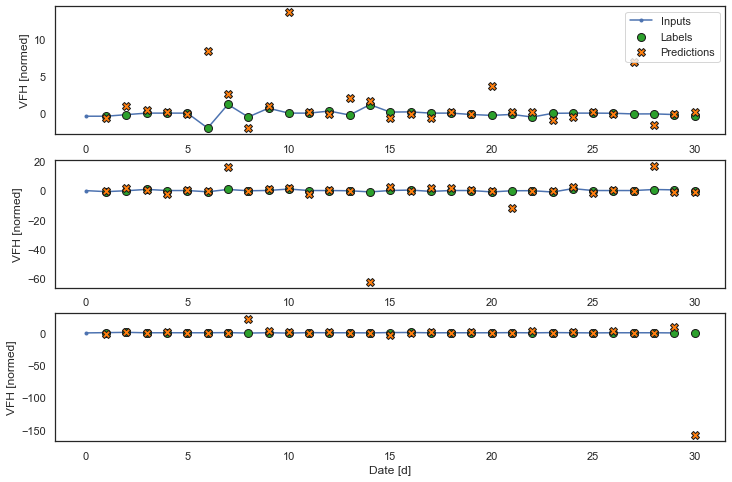

In [52]:
wide_window.plot(linear,target_etf)


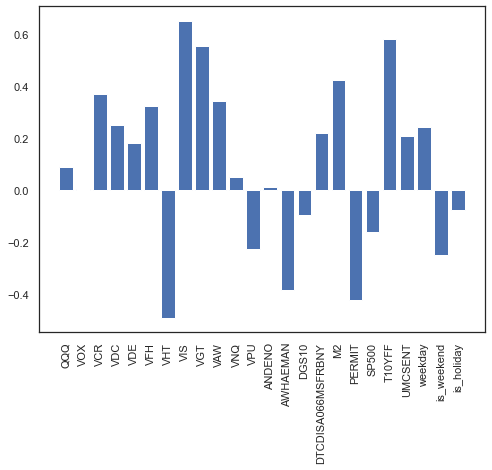

In [53]:
# pull out the layer's weights, and see the weight assigned to each input:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [54]:
# Dense
# checking the performance of deeper, more powerful, single input step models.
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
40/40 [==============================] - 1s 13ms/step - loss: 641.7355 - mean_absolute_error: 3.1711 - val_loss: 26.0066 - val_mean_absolute_error: 1.5021
Epoch 2/20
40/40 [==============================] - 0s 7ms/step - loss: 5.6260 - mean_absolute_error: 0.6066 - val_loss: 3.3095 - val_mean_absolute_error: 0.9257
Epoch 3/20
40/40 [==============================] - 0s 7ms/step - loss: 0.6141 - mean_absolute_error: 0.4014 - val_loss: 1.9926 - val_mean_absolute_error: 0.8237
Epoch 4/20
40/40 [==============================] - 0s 7ms/step - loss: 0.3157 - mean_absolute_error: 0.3623 - val_loss: 1.8673 - val_mean_absolute_error: 0.7886
Epoch 5/20
40/40 [==============================] - 0s 7ms/step - loss: 0.2765 - mean_absolute_error: 0.3399 - val_loss: 1.8861 - val_mean_absolute_error: 0.7881
Epoch 6/20
40/40 [==============================] - 0s 8ms/step - loss: 0.2816 - mean_absolute_error: 0.3370 - val_loss: 1.8310 - val_mean_absolute_error: 0.7684
Epoch 7/20
40/40 [======

In [55]:
CONV_WIDTH = n_input_width
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[target_etf])

conv_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['VFH']

Text(0.5, 1.0, 'Given 30d as input, predict 1d into the future.')

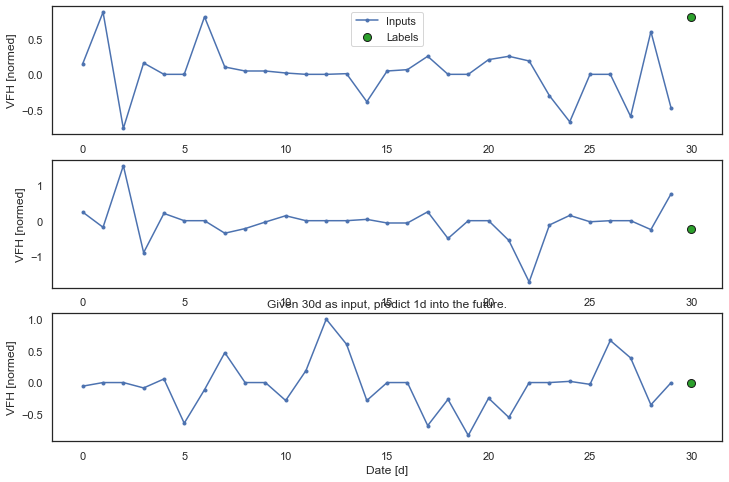

In [56]:
conv_window.plot(plot_col=target_etf)
plt.title(f"Given {n_input_width}d as input, predict 1d into the future.")

In [57]:
# multi step dense
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [58]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 30, 24)
Output shape: (32, 1, 1)


In [59]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

11/11 [==============================] - 0s 2ms/step - loss: 131.0972 - mean_absolute_error: 6.1861


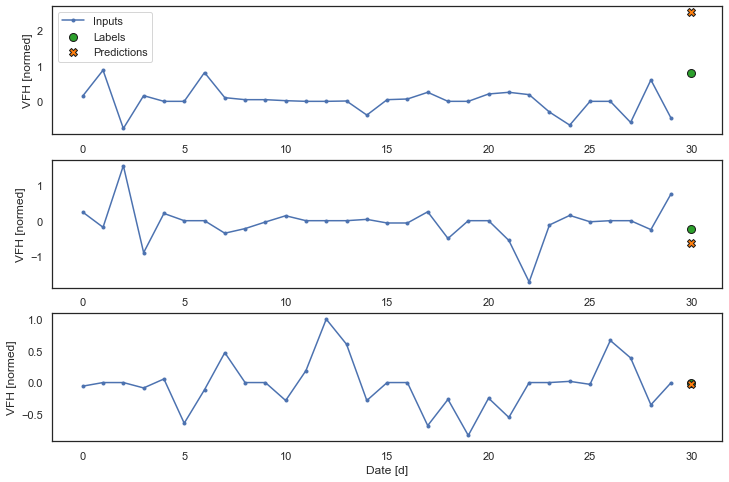

In [60]:
conv_window.plot(multi_step_dense, target_etf)

In [61]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 30, 24)
Output shape: (32, 1, 1)


In [62]:
# Convolution neural network
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [63]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 30, 24)
Output shape: (32, 1, 1)


In [64]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

11/11 [==============================] - 0s 2ms/step - loss: 469.6910 - mean_absolute_error: 10.4571


In [65]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)


Wide window
Input shape: (32, 30, 24)
Labels shape: (32, 30, 1)
Output shape: (32, 1, 1)


In [66]:
LABEL_WIDTH = n_input_width
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=[target_etf])

wide_conv_window

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): ['VFH']

In [67]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 59, 24)
Labels shape: (32, 30, 1)
Output shape: (32, 30, 1)


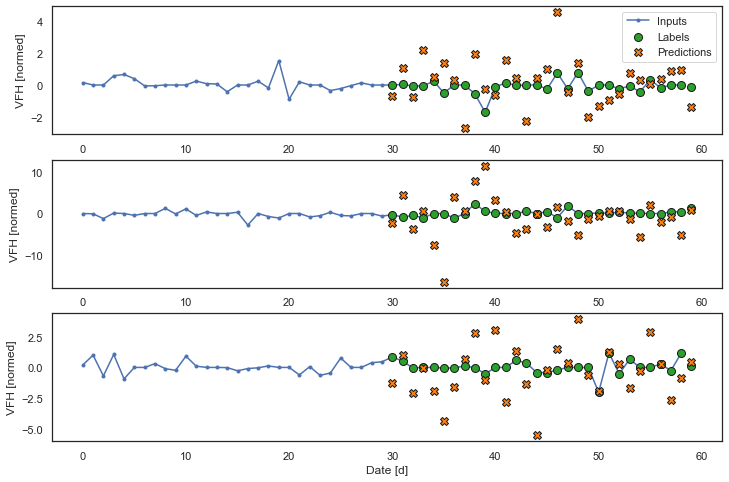

In [68]:
wide_conv_window.plot(conv_model,target_etf)


In [69]:
# Recurrent neural network
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [70]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 30, 24)
Output shape: (32, 30, 1)


In [71]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)


11/11 [==============================] - 0s 4ms/step - loss: 1.8157 - mean_absolute_error: 0.7560


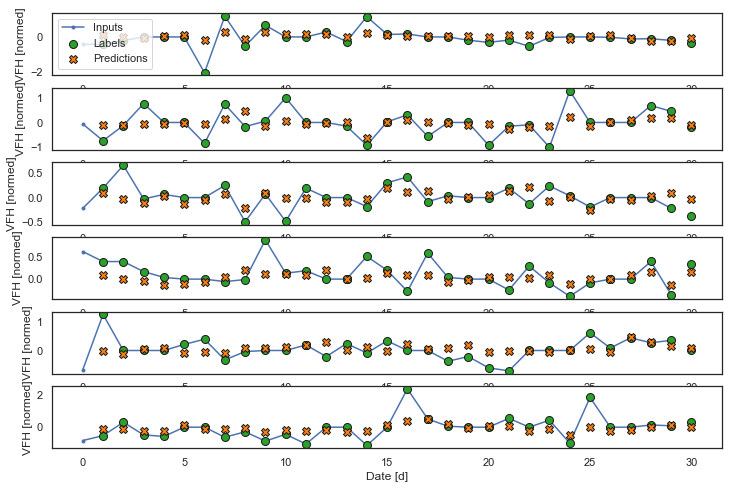

In [72]:
wide_window.plot(lstm_model,target_etf,max_subplots=6)

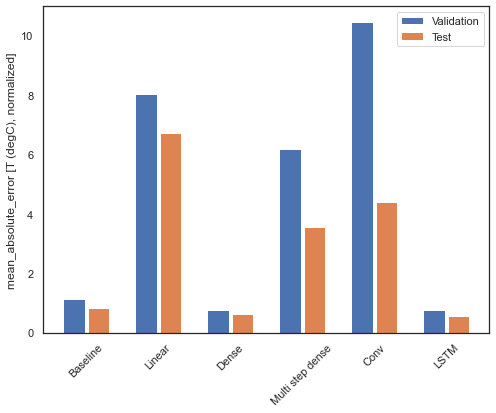

In [73]:
# Performance
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [74]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.8222
Linear      : 6.7082
Dense       : 0.6079
Multi step dense: 3.5515
Conv        : 4.3827
LSTM        : 0.5420


### Single step models

In [75]:
# Multi-output models
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=n_input_width, label_width=n_input_width, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 24)
Labels shape (batch, time, features): (32, 30, 24)


In [76]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [77]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

11/11 [==============================] - 0s 2ms/step - loss: 265916.4479 - mean_absolute_error: 22.5027


In [78]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [79]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

12/12 [==============================] - 0s 2ms/step - loss: 118875.2969 - mean_absolute_error: 13.3922


In [80]:
%%time
wide_window = WindowGenerator(
    input_width=n_input_width, label_width=n_input_width, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

11/11 [==============================] - 0s 4ms/step - loss: 126909.8359 - mean_absolute_error: 11.7587

CPU times: user 8.34 s, sys: 1.06 s, total: 9.4 s
Wall time: 6.23 s


In [81]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [82]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

11/11 [==============================] - 0s 4ms/step - loss: 253537.8750 - mean_absolute_error: 22.5726

CPU times: user 24.9 s, sys: 3.67 s, total: 28.6 s
Wall time: 16.9 s


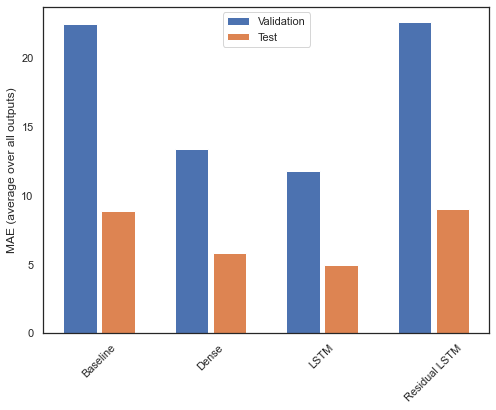

In [83]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [84]:
for name, value in performance.items():
    print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 8.8934
Dense          : 5.8325
LSTM           : 4.9390
Residual LSTM  : 9.0027


## Multi-step models

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): None

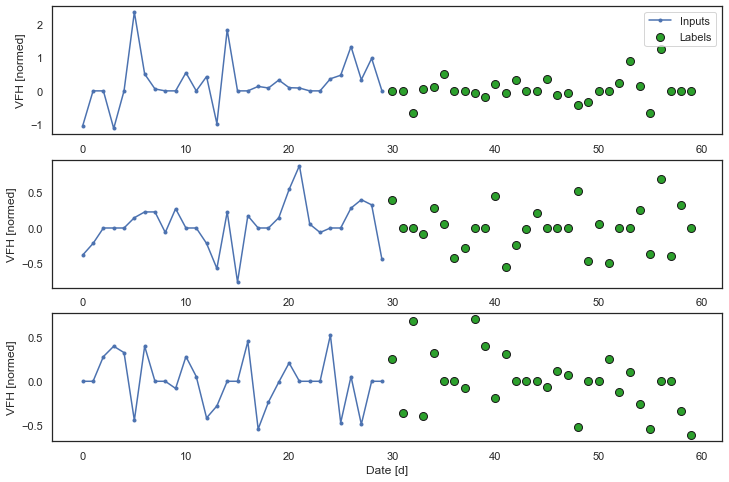

In [85]:
OUT_STEPS = n_input_width
multi_window = WindowGenerator(input_width=n_input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot(plot_col=target_etf)
multi_window

### Baseline

10/10 [==============================] - 0s 1ms/step - loss: 327325.6548 - mean_absolute_error: 24.2730


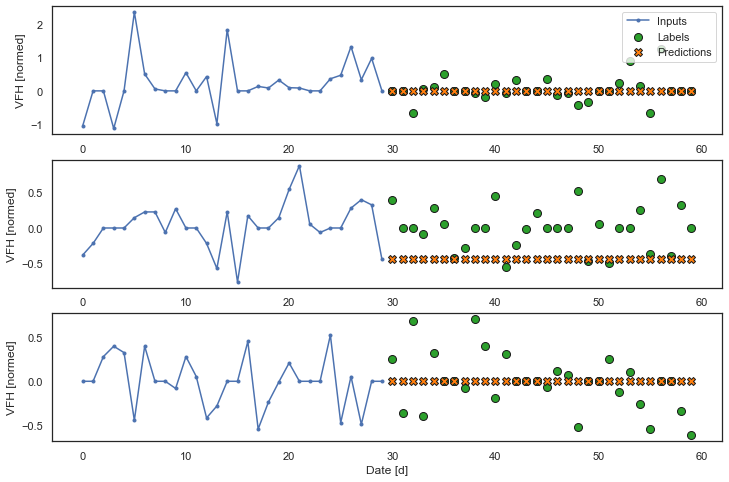

In [86]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline, plot_col=target_etf)

10/10 [==============================] - 0s 2ms/step - loss: 276489.3210 - mean_absolute_error: 22.4166


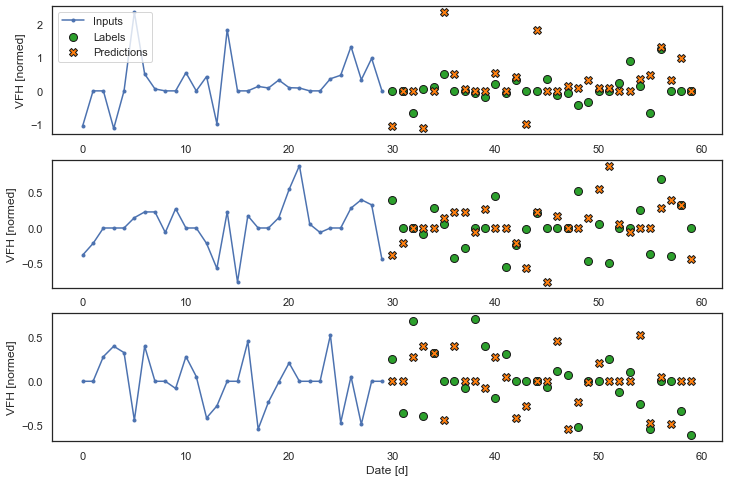

In [87]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline, plot_col=target_etf)

### Single-shot models

10/10 [==============================] - 0s 2ms/step - loss: 138399.3281 - mean_absolute_error: 12.4030


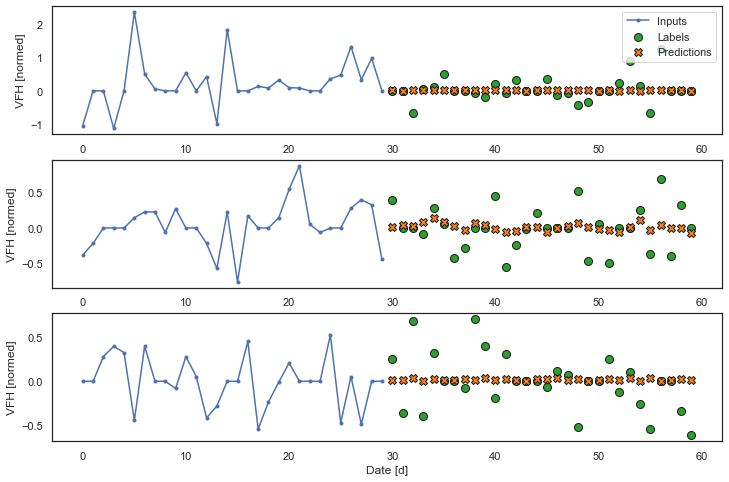

In [88]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model, plot_col=target_etf)

### Dense

10/10 [==============================] - 0s 3ms/step - loss: 138712.9219 - mean_absolute_error: 14.0066


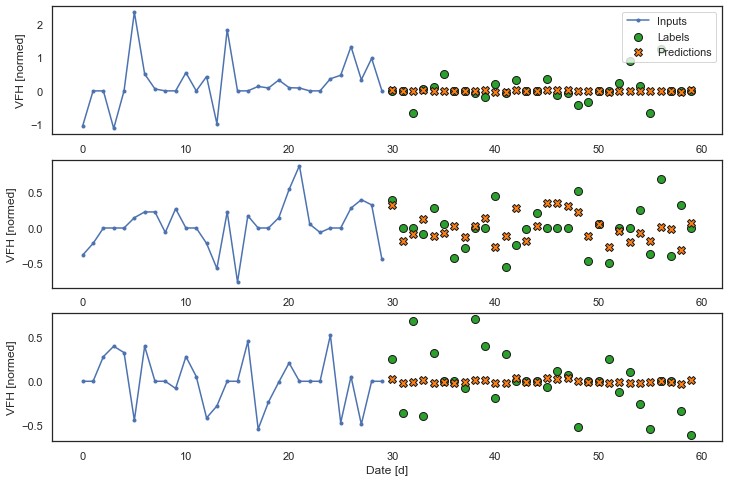

In [89]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model, plot_col=target_etf)

10/10 [==============================] - 0s 2ms/step - loss: 138294.8750 - mean_absolute_error: 14.6652


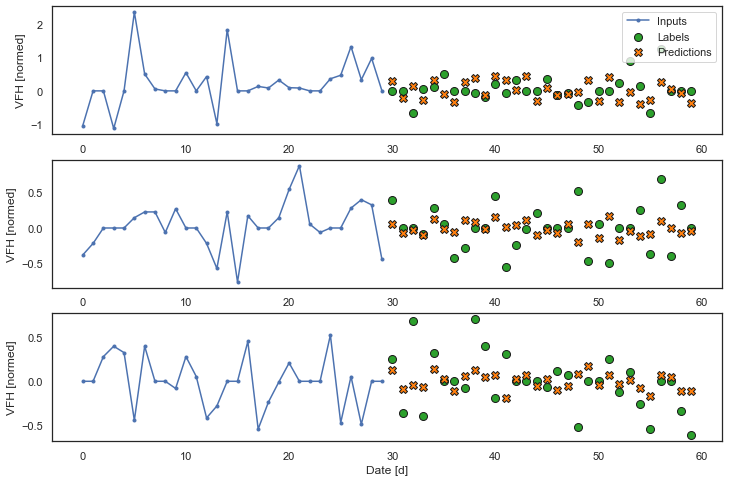

In [90]:
# CNN
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model, plot_col=target_etf)

10/10 [==============================] - 0s 4ms/step - loss: 138400.1562 - mean_absolute_error: 12.3179


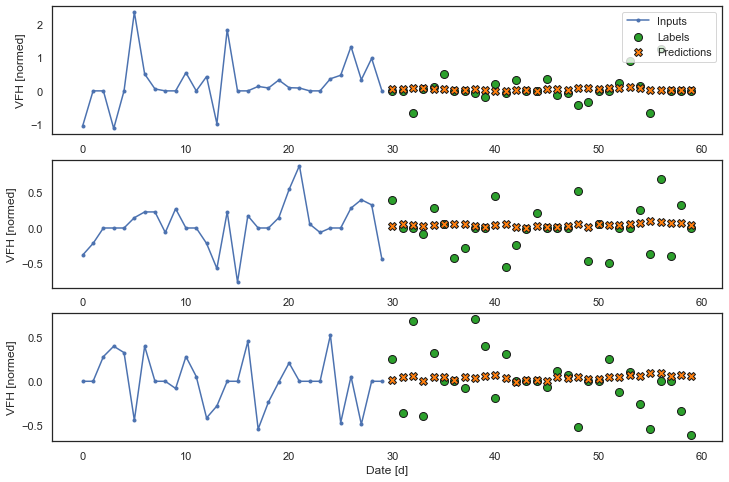

In [91]:
# RNN
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model, plot_col=target_etf)

### Advanced: Autoregressive model

In [92]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [93]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [94]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [95]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 24])

In [96]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [97]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 30, 24)


10/10 [==============================] - 0s 6ms/step - loss: 138415.5469 - mean_absolute_error: 12.9647


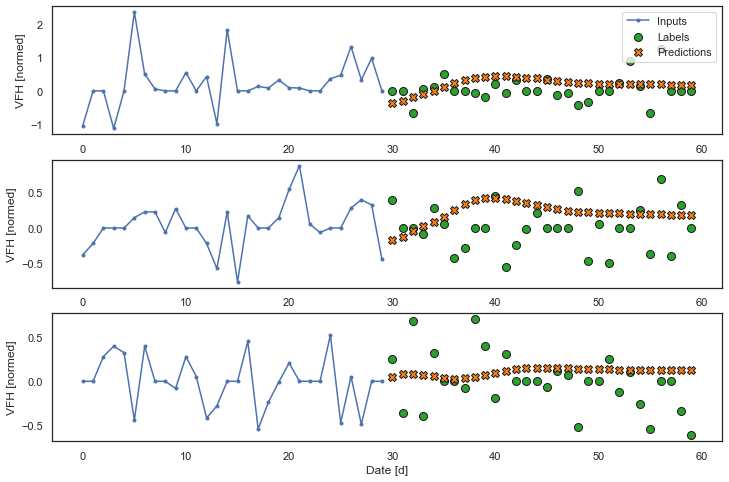

In [98]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model, plot_col=target_etf)

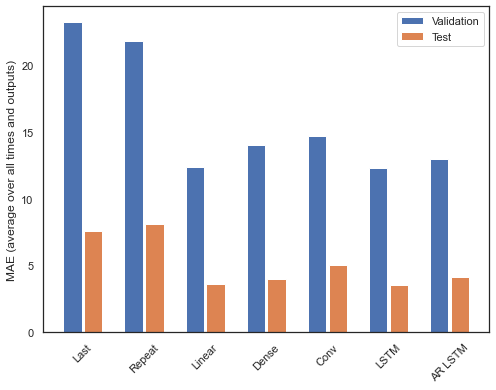

In [99]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [100]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 7.5525
Repeat  : 8.0914
Linear  : 3.5985
Dense   : 3.9999
Conv    : 5.0703
LSTM    : 3.5325
AR LSTM : 4.1215


### Predict

In [101]:
# transform data to create prediction

# final_window = single_step_window
# final_model = dense

# final_window = wide_window
# final_model = lstm_model

final_window = multi_window
final_model = multi_linear_model #multi_lstm_model # or multi_linear_model #

final_window_size = final_window.input_width


# actual_df_std = (df - train_mean) / train_std
actual_df_std = df.diff(diff_order).dropna()
actual_df_std = actual_df_std[-final_window_size:]



In [102]:
# create prediction
def make_pred_dataset(self, data):
#     data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.input_width,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
    return ds

WindowGenerator.make_pred_dataset = make_pred_dataset

predictions = final_model.predict(final_window.make_pred_dataset(actual_df_std))
# predictions = final_model.predict([np.array(actual_df_std, dtype=np.float32)])
print("predictions shape:", predictions.shape)   

predictions shape: (1, 30, 24)


In [103]:
# reverse the prediction
predictions_reversed = pd.DataFrame(data = predictions[0],columns=plot_cols)
# method to reverse prediction to the original scale as we used 1 degree difference to preprocess data
predictions_reversed = np.cumsum(predictions_reversed,axis=0)  + df[-1:].values
# method to reverse prediction to the original scale if we used normalization to preprocess data
# predictions_reversed = predictions_reversed*train_std+train_mean

predictions_reversed.index = pd.date_range(forecast_start_date,periods=predictions_reversed.shape[0],freq='D').date

In [104]:
# compare current with predicted future
current_reversed = df.copy()
# current_reversed = actual_df_std.copy()
current = current_reversed[etf_list].tail(1).values
future1 = np.array(predictions_reversed[etf_list].mean())
future2 = predictions_reversed[etf_list].tail(1).values
future_tomorrow = predictions_reversed[etf_list].head(1).values

In [111]:
print("The higher the rank, the more recomended to invest in:")
pd.DataFrame(data={'etf':etf_list,
                   '% change by mean':(future1/current-1)[0], 
                   'rank1': rankdata((future1/current-1)[0], method='min'),
                   '% change by last value':(future2/current-1)[0],
                  'rank2': rankdata((future2/current-1)[0], method='min'),
                    '% change by tomorrow':(future_tomorrow/current-1)[0],
                  'rank3': rankdata((future_tomorrow/current-1)[0], method='min')
                  })


The higher the rank, the more recomended to invest in:


etf  % change by mean  rank1  % change by last value  rank2  \
0   QQQ            0.0007      3                  0.0015      4   
1   VOX           -0.0012      1                 -0.0042      1   
2   VCR            0.0009      6                  0.0023      7   
3   VDC            0.0021      8                  0.0027      8   
4   VDE            0.0043     12                  0.0045     10   
5   VFH            0.0032     10                  0.0063     12   
6   VHT            0.0006      2                  0.0000      2   
7   VIS            0.0027      9                  0.0047     11   
8   VGT            0.0009      4                  0.0022      6   
9   VAW            0.0013      7                  0.0016      5   
10  VNQ            0.0009      5                  0.0002      3   
11  VPU            0.0037     11                  0.0033      9   

    % change by tomorrow  rank3  
0                -0.0004      6  
1                -0.0014      2  
2                -0.0004      7  
3                -0.0001     11  
4                -0.0014      3  
5                -0.0006      4  
6                -0.0002     10  
7                -0.0002      9  
8                -0.0004      8  
9                -0.0000     12  
10               -0.0016      1  
11               -0.0005      5

In [106]:
# plot the current and predicted future
final_actual = current_reversed[etf_list+leading_metric_list].copy()
final_actual['Type'] = 'Actual'
final_pred = predictions_reversed[etf_list+leading_metric_list].copy()
final_pred['Type'] = 'Prediction'

final_df = final_actual.append(final_pred)
final_df['Created Date']=train_end_date

In [112]:
# store the actual and prediction
final_df.to_csv(os.path.join(project_dir, f'data/processed/ts_leading_metric_impact_on_sectors_pred_{train_end_date}.csv'), encoding='utf-8', index=False)


## Visualization

In [115]:
# visualize ETFs
# colors
palette = cycle(px.colors.qualitative.Bold)

max_y = final_df[etf_list].max().max()
n_digit = 10 ** (len(str(int(max_y)))-1)
data = []
for etf in etf_list:
    trace_color = next(palette)
    # TODO: add ETF name
    trace_actual = go.Scatter(x=final_actual.index, y=final_actual[etf],
                    mode='lines',
                    name=f'{etf}-actual',
                             line=go.Line(color=trace_color,
                                         width=1.5,))
    trace_pred = go.Scatter(x=final_pred.index, y=final_pred[etf],
                    mode='lines',
                    name=f'{etf}-prediction',
                           line=go.Line(color=trace_color,
                                       width=1.5,
                                       dash='dashdot'))
    data.append(trace_actual)
    data.append(trace_pred)

layout = go.Layout(title='ETF',
                  xaxis=dict(title='Date'),
                  yaxis=dict(title='Value'))
layout.update(dict(shapes=[
    {
        'type':'line',
        'x0':train_end_date,
        'y0':0,
        'x1':train_end_date,
        'y1':np.ceil(max_y/n_digit)*n_digit,
        'line':{
            'color':'#909090',
            'width':1
        }
        
    }
]))
layout.update(dict(annotations=[
    go.Annotation(text='End of training',
                 x=train_end_date,
                 y=np.floor(max_y/n_digit)*n_digit
                  )
]))
fig = go.Figure(data = data,layout=layout)

fig.show()

In [116]:
# visualize leading metrics


# colors
palette = cycle(px.colors.qualitative.Vivid)

max_y = final_df[leading_metric_list].max().max()
n_digit = 10 ** (len(str(int(max_y)))-1)
data = []
for leading_metric in leading_metric_list:
    trace_color = next(palette)
    trace_actual = go.Scatter(x=final_actual.index, y=final_actual[leading_metric],
                    mode='lines',
                    name=f'{leading_metric}-actual',
                             line=go.Line(color=trace_color,
                                         width=1.5,))
    trace_pred = go.Scatter(x=final_pred.index, y=final_pred[leading_metric],
                    mode='lines',
                    name=f'{leading_metric}-prediction',
                           line=go.Line(color=trace_color,
                                       width=1.5,
                                       dash='dashdot'))
    data.append(trace_actual)
    data.append(trace_pred)

layout = go.Layout(title='Leading Metrics',
                  xaxis=dict(title='Date'),
                  yaxis=dict(title='Value'))
layout.update(dict(shapes=[
    {
        'type':'line',
        'x0':train_end_date,
        'y0':0,
        'x1':train_end_date,
        'y1':np.ceil(max_y/n_digit)*n_digit,
        'line':{
            'color':'#909090',
            'width':1
        }
        
    }
]))
layout.update(dict(annotations=[
    go.Annotation(text='End of training',
                 x=train_end_date,
                 y=np.floor(max_y/n_digit)*n_digit
                  )
]))
fig = go.Figure(data = data,layout=layout)

fig.show()